In [34]:
import pandas as pd
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
from statsmodels.api import OLS
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import chain
import seaborn 
import pickle
import sklearn.metrics as sk
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

## Pattern Statistics (all and experiment only) ##

In [35]:
## Get Experiment Pattern Indices ##
# Reasoning later in document #
test_patterns_indices = np.array([894, 423, 1367, 249, 939, 427, 590, 143, 912, 580, 1043, 673, 1359, 736, 678, 1355], dtype=float)
control_patterns = [678, 1355]
n_subjects = 43

In [36]:
## Extract Pattern Data ##
patterns_file = open(os.getcwd()+"/data/patterns.pkl", 'rb')
_patterns = pickle.load(patterns_file)
patterns_file.close()
n_patterns = len(_patterns)
print(n_patterns)

1378


In [37]:
## Partition Data ##
patterns = np.array([[[0, 0, 0] for x in range(16)] for y in range(n_patterns)], dtype=float) # (1378, 16, 3)

# Puts low/mid/high notes per step into workable array
for patt in range(n_patterns): # 1378
    for step in range(16): # 16
        for note in range(len(_patterns[patt][step])): # num notes on that step
            if _patterns[patt][step][note] == 1: # low channel note
                patterns[patt][step][0] += 1
            if _patterns[patt][step][note] == 2: # mid channel note
                patterns[patt][step][1] += 1
            if _patterns[patt][step][note] == 3: # high channel note
                patterns[patt][step][2] += 1

print("Example:")
for i in range(16):
    print(f"{i+1}: {_patterns[340][i]} --> {patterns[340][i]}")

Example:
1: [1, 3] --> [1. 0. 1.]
2: [2, 3] --> [0. 1. 1.]
3: [3, 2] --> [0. 1. 1.]
4: [2, 2] --> [0. 2. 0.]
5: [1, 2, 2, 3] --> [1. 2. 1.]
6: [] --> [0. 0. 0.]
7: [2, 3, 3] --> [0. 1. 2.]
8: [3] --> [0. 0. 1.]
9: [1, 2] --> [1. 1. 0.]
10: [3] --> [0. 0. 1.]
11: [2, 3, 2] --> [0. 2. 1.]
12: [2, 3] --> [0. 1. 1.]
13: [1, 2, 3] --> [1. 1. 1.]
14: [2, 3, 3] --> [0. 1. 2.]
15: [] --> [0. 0. 0.]
16: [2, 2] --> [0. 2. 0.]


In [38]:
## Characteristics of dataset patterns and selected patterns ##
note_counts = np.array([0.0 for x in range(5)], dtype=float) # [low,mid,high,rests,total]
exp_note_counts = note_counts.copy()

note_counts_by_step = np.array([[0.0 for x in range(4)] for y in range(16)], dtype=float) # [low,mid,high,total]
exp_note_counts_by_step = note_counts_by_step.copy()

for patt in range(n_patterns):
    for step in range(16):
        isrest=1
        for channel in range(3):
            value = patterns[patt][step][channel]
            
            if value > 0.1: # condition checking for all three channels not having a note
                isrest=0

            note_counts[channel] += value
            note_counts_by_step[step][channel] += value # per channel
            note_counts_by_step[step][3] += value # sum notes

            if np.isin(patt, test_patterns_indices): # if used in exp
                exp_note_counts[channel] += value
                exp_note_counts_by_step[step][channel] += value # per channel
                exp_note_counts_by_step[step][3] += value # sum notes

        if isrest==1: # remainder of rest check
            note_counts[3] += 1
            if np.isin(patt, test_patterns_indices):
                exp_note_counts[3] += 1
            

note_counts[4] = np.sum(note_counts[0:3])
exp_note_counts[4] = np.sum(exp_note_counts[0:3])
_note_counts_by_step = note_counts_by_step.T
_exp_note_counts_by_step = exp_note_counts_by_step.T
print(f"note cnts {note_counts}")
print(f"exp note cnts {exp_note_counts}")

note cnts [ 6238. 10708. 19208.  3799. 36154.]
exp note cnts [ 74. 113. 209.  48. 396.]


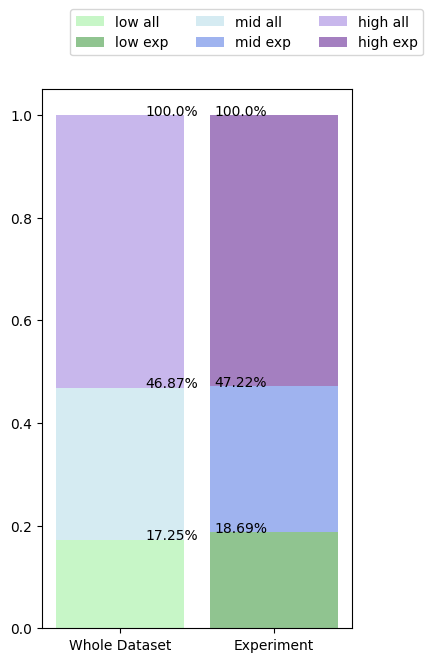

In [39]:
## Plotting percentages ##
colors_light=['lightgreen','lightblue','mediumpurple']
colors_dark=['forestgreen', 'royalblue','indigo']

fig, (ax) = plt.subplots(figsize=(4,7))
bottom =[0,0]
boxes =["low all","mid all", "high all","low exp", "mid exp", "high exp"]
for i in range(3):
    ax.bar(0.2,note_counts[i]/note_counts[4], color=colors_light[i], alpha=0.5,width=0.5, bottom=bottom[0], label=boxes[i])
    bottom[0] += note_counts[i]/note_counts[4]
    txt = np.round(bottom[0]*100, 2)
    ax.text(0.3, bottom[0], str(txt)+"%")

    ax.bar(0.8,exp_note_counts[i]/exp_note_counts[4], color=colors_dark[i], alpha=0.5,width=0.5, bottom=bottom[1], label=boxes[i+3])
    bottom[1] += exp_note_counts[i]/exp_note_counts[4]
    txt2 = np.round(bottom[1]*100, 2)
    ax.text(0.57, bottom[1], str(txt2)+"%")

ax.legend(bbox_to_anchor=([0.07, 1.05]), ncols=3)
ax.set_xticks([0.2,0.8])
ax.set_xticklabels(["Whole Dataset", "Experiment"])
plt.show()

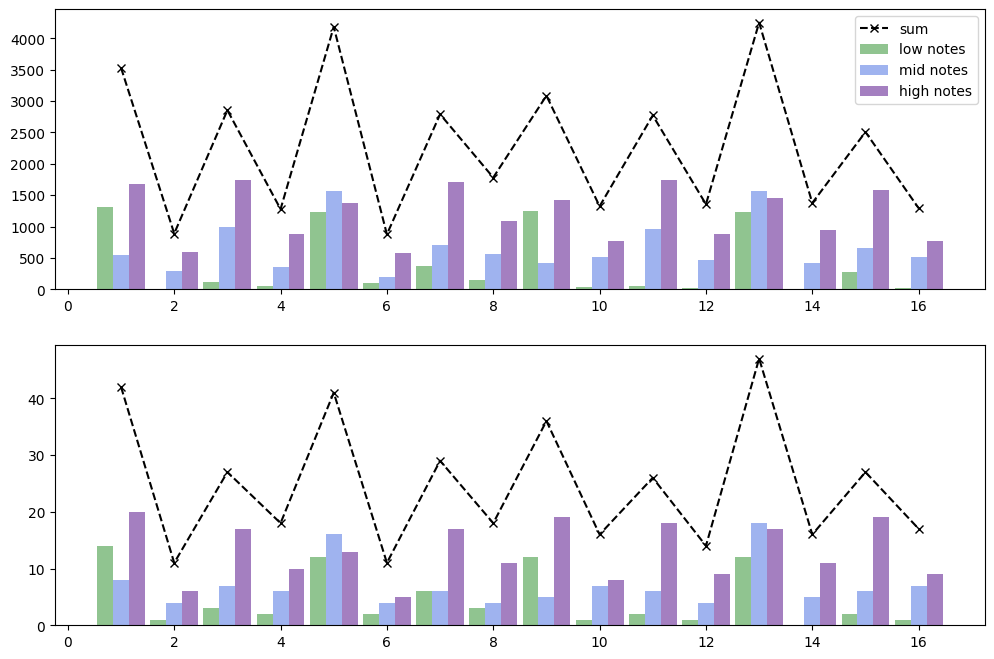

In [40]:
## Plot note distributions (OLD) ##
colors_light=['lightgreen','lightblue','mediumpurple']
colors_dark=['forestgreen', 'royalblue','indigo']

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
idx = np.arange(16)+1
idx_l = idx-0.3
idx_r = idx+0.3
pos=[-0.45,0.0,0.45]
bar_width = 0.3
ax1.bar(idx_l,_note_counts_by_step[0],color=colors_dark[0], alpha=0.5, width=bar_width, label="low notes")
ax2.bar(idx_l,_exp_note_counts_by_step[0], color=colors_dark[0], alpha=0.5, width=bar_width, label="low notes")

ax1.bar(idx,_note_counts_by_step[1],color=colors_dark[1], alpha=0.5, width=bar_width, label="mid notes")
ax2.bar(idx,_exp_note_counts_by_step[1], color=colors_dark[1], alpha=0.5, width=bar_width, label="mid notes")

ax1.bar(idx_r,_note_counts_by_step[2],color=colors_dark[2], alpha=0.5, width=bar_width, label="high notes")
ax2.bar(idx_r,_exp_note_counts_by_step[2], color=colors_dark[2], alpha=0.5, width=bar_width, label="high notes")

ax1.plot(idx, np.sum(_note_counts_by_step[:3], axis=0), color='black', linestyle="--", marker="x", label="sum")
ax2.plot(idx, np.sum(_exp_note_counts_by_step[:3], axis=0), color='black', linestyle="--", marker="x", label="sum")

ax1.legend()
plt.show()

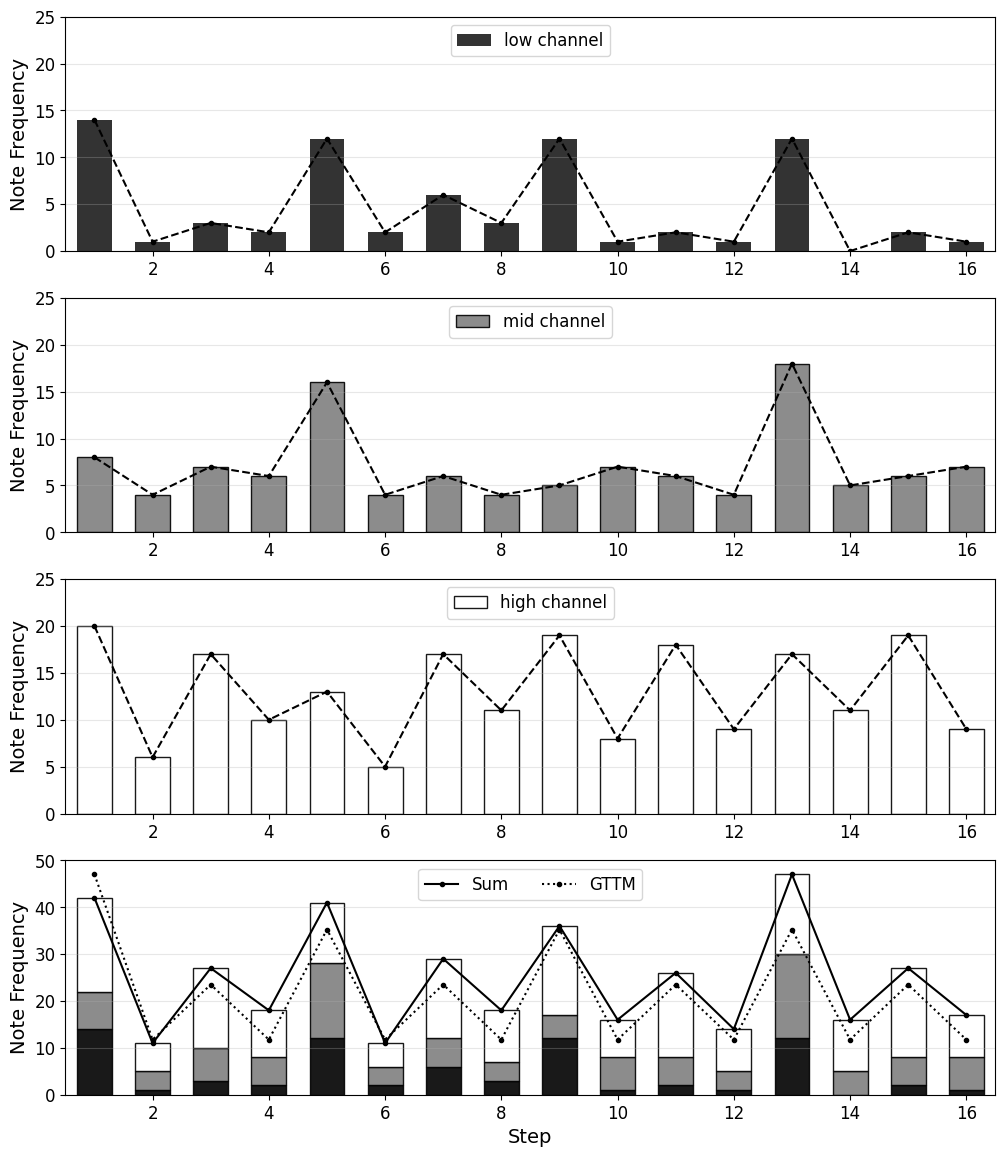

In [41]:
## Plot note distributions by step and channel ##
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,14))
#fig.subplots_adjust(hspace=0.3)

colors_light=['lightgreen','lightblue','mediumpurple']
colors_dark=['forestgreen', 'royalblue','indigo']

colors=["black","gray","white"]
idx = np.arange(16)+1
idx_l = idx-0.3
idx_r = idx+0.3
pos=[-0.45,0.0,0.45]
bar_width = 0.6
ax1.bar(idx,_exp_note_counts_by_step[0], color=colors[0], alpha=0.8, width=bar_width, label="low channel")

ax2.bar(idx,_exp_note_counts_by_step[1], color=colors[1], alpha=0.9, width=bar_width, label="mid channel", edgecolor='black')

ax3.bar(idx,_exp_note_counts_by_step[2], color=colors[2], alpha=0.9, width=bar_width, label="high channel", edgecolor='black')
bottom=np.array([0.0 for x in range(16)])
for i in range(3):
    ax4.bar(idx, _exp_note_counts_by_step[i], color=colors[i], alpha=0.9,width=bar_width, label="sum", bottom=bottom, edgecolor='black')
    bottom += _exp_note_counts_by_step[i]

ax1.plot(idx, _exp_note_counts_by_step[0], color='black', linestyle="--", marker=".")
ax2.plot(idx, _exp_note_counts_by_step[1], color='black', linestyle="--", marker=".")
ax3.plot(idx, _exp_note_counts_by_step[2], color='black', linestyle="--", marker=".")
line, =ax4.plot(idx, _exp_note_counts_by_step[3], color='black', linestyle="-", marker=".")

gttm = np.array([4,1,2,1,3,1,2,1,3,1,2,1,3,1,2,1],dtype=float)
gttm /= np.max(gttm)
gttm *= np.max(_exp_note_counts_by_step[3])
line2, =ax4.plot(idx, gttm, color='black', linestyle=":", marker=".")

plts = [ax1,ax2,ax3,ax4]
for p in plts:
    p.grid(alpha=0.3, axis='y')
    p.tick_params(labelsize=12)
    if p!=ax4:
        p.legend(loc='upper center', ncols=1, fontsize="large")
    p.set_xlim([0.5,16.5])
    p.set_ylim([0,25])
    p.set_ylabel("Note Frequency", fontsize=14)
ax4.set_xlabel("Step", fontsize=14)
ax4.set_ylim([0,50])

ax4.legend([line, line2], ("Sum", "GTTM"), loc="upper center", ncols=2, fontsize="large")
plt.show()


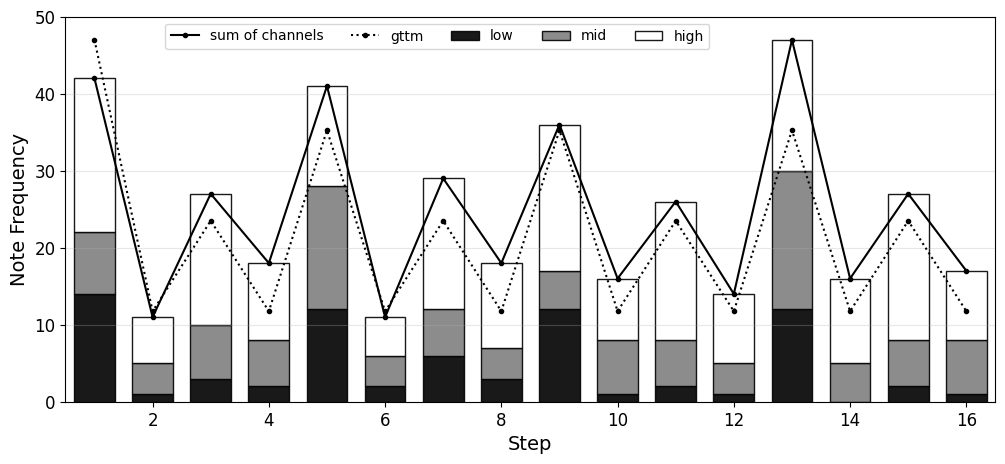

In [42]:
## Plot last graph from cell above ##
fig, (ax4) = plt.subplots(figsize=(12,5))
names=["low","mid","high"]
colors=["black","gray","white"]
mpl.rcParams['hatch.color'] = 'white'
bottom=np.array([0.0 for x in range(16)])
for i in range(3):
    ax4.bar(idx, _exp_note_counts_by_step[i], color=colors[i], alpha=0.9,width=.7, label=f"{names[i]}", bottom=bottom, edgecolor="black")
    bottom += _exp_note_counts_by_step[i]
line, =ax4.plot(idx, _exp_note_counts_by_step[3], color='black', linestyle="-", marker=".", label="sum of channels")

gttm = np.array([4,1,2,1,3,1,2,1,3,1,2,1,3,1,2,1],dtype=float)
gttm /= np.max(gttm)
gttm *= np.max(_exp_note_counts_by_step[3])
line2, =ax4.plot(idx, gttm, color='black', linestyle=":", marker=".", label='gttm')

plts = [ax4]
for p in plts:
    p.grid(alpha=0.3, axis='y')
    if p!=ax4:
        p.legend(loc='upper center', ncols=1)
    p.set_xlim([0.5,16.5])
    p.set_ylim([0,25])
    p.set_ylabel("Note Frequency", fontsize=14)
    ax4.set_ylim([0,50])
ax4.tick_params(labelsize=12)
ax4.set_xlabel("Step", fontsize=14)
ax4.legend(loc="upper center", ncols=5,bbox_to_anchor=[.4,1])
plt.show()

## Experiment Statistics ##

In [43]:
## Extract experiment data ##
data = []
tap_file = os.getcwd()+"/data/tapexplore.csv"
with open(tap_file) as results: 
    reader = csv.reader(results)
    for row in reader:
        data.append(row)
    results.close()


In [44]:
## Clean csv file (if necessary) ## 
_tap_data = []
for row in data:
    line = row[2:20]
    _tap_data.append(line)
for i in range(3):
    print(_tap_data[i])

['NAME', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15', 't16', 'c1']
['1355', 'breakbeat_unconventional_DMR_1', '0.716535433', '0', '0', '0', '0.661417323', '0', '0.700787402', '0', '0', '0', '0.716535433', '0', '0.732283465', '0', '0', '0']
['1043', 'chicago_promisedland_138', '0.496062992', '0', '0.417322835', '0', '0.488188976', '0', '0', '0', '0.42519685', '0', '0.456692913', '0', '0.480314961', '0', '0', '0']


In [45]:
tap_data = np.array([[[0.0 for x in range(17)] for y in range(18)] for z in range(n_subjects)], dtype=float)
tap_data_pattern = np.array([[[0.0 for x in range(16)] for y in range(n_subjects)] for z in range(18)], dtype=float)
tap_data_subjects = np.array([[[0.0 for x in range(16)] for y in range(18)] for z in range(n_subjects)], dtype=float)
tap_data_controls = np.array([[[0.0 for x in range(16)] for y in range(4)] for z in range(n_subjects)], dtype=float)
n=0
subj=0
ctrl=[0,0]

_tap_data_no_header = _tap_data[1:]
long_index = 0
for n in range(n_subjects): 
    for t in range(18):
        # tap data looks like this now: (subj, tap_in_exp_order, index+16steps)
        tap_data[n][t][0] = _tap_data_no_header[long_index][0]
        tap_data[n][t][1:] = _tap_data_no_header[long_index][2:]
        long_index+=1
        #if n==13:
        #    print(" ".join([f"{x:.2f}" for x in tap_data[n][t]]))

for n in range(n_subjects):
    # for each person
    tap_results = tap_data[n] #(18patts,17(idx+16steps))
    for p in range(len(tap_results)):
        # for all 18 patterns tapped
        pattern_num=int(tap_results[p][0])
        pattern_index = np.where(pattern_num==test_patterns_indices)[0][0]

        # control check (if second appearance, place at end)
        # for tap_data_controls
        if ctrl[0]>0 and pattern_num==678:
            tap_data_controls[n][1] = tap_results[p][1:]
            pattern_index = 16
        if ctrl[1]>0 and pattern_num==1355:
            tap_data_controls[n][3] = tap_results[p][1:]
            pattern_index = 17
        
        # control check for first appearance
        if pattern_num==678 and ctrl[0]==0:
            tap_data_controls[n][0] = tap_results[p][1:]
            ctrl[0]+=1
            
        if pattern_num==1355 and ctrl[1]==0:
            tap_data_controls[n][2] = tap_results[p][1:]
            ctrl[1]+=1

        # both are sorted by test_patterns order (very first cell)
        tap_data_pattern[pattern_index][n] = tap_results[p][1:]
        tap_data_subjects[n][pattern_index] = tap_results[p][1:]
    
    ctrl=[0,0] # reset for next subj

#print((tap_data_controls[1,0]-tap_data_controls[1,1])) # subj 2, 678 1st minus 2nd

print(tap_data.shape)
print(tap_data_pattern.shape)
print(tap_data_subjects.shape)
print(tap_data_controls.shape)


(43, 18, 17)
(18, 43, 16)
(43, 18, 16)
(43, 4, 16)


control_precision - (43, 2, 16)
precision_means - (43, 2)
678: m=0.170 sd=0.118
1355: m=0.118 sd=0.099
0.4065 0.3155
outliers: 5 [[6, 17, 20, 31, 35]]


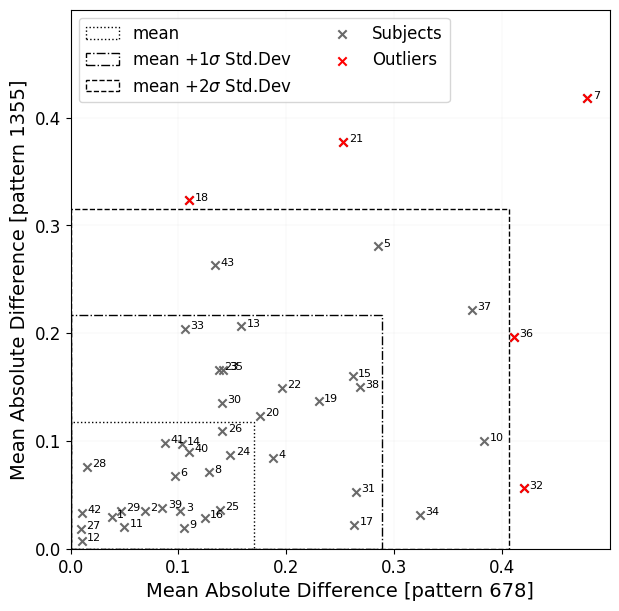

In [46]:
## outlier selection and splitting ##
fig, (ax1) = plt.subplots(figsize=(7,7))
ax1.set_aspect('equal')

control_precision = np.array([[[0.0 for x in range(16)] for y in range(2)] for z in range(n_subjects)], dtype=float)
control_means = np.array([[0.0 for x in range(16)] for y in range(2)], dtype=float)


for n in range(n_subjects): # find differences in tapping to same pattern
    control_precision[n][0] = (tap_data_controls[n][0]-tap_data_controls[n][1]) # 678
    control_precision[n][1] = (tap_data_controls[n][2]-tap_data_controls[n][3]) # 1355

    control_means[0] += (tap_data_controls[n][0]+tap_data_controls[n][1])/2
    control_means[1] += (tap_data_controls[n][2]+tap_data_controls[n][3])/2
control_means[:] /= n_subjects

precision_means = np.mean(np.abs(control_precision), axis=2) #(43,2)
print(f"control_precision - {control_precision.shape}")
print(f"precision_means - {precision_means.shape}")
print(f"678: m={np.mean(np.abs(precision_means[:,0])):.3f} sd={np.std(precision_means[:,0]):.3f}")
print(f"1355: m={np.mean(np.abs(precision_means[:,1])):.3f} sd={np.std(precision_means[:,1]):.3f}")



# Get std devs of precision per pattern
sd_678=2*np.std(precision_means[:,0])+np.mean(np.abs(precision_means[:,0]))
sd_1355=2*np.std(precision_means[:,1])+np.mean(np.abs(precision_means[:,1]))
print(f"{sd_678:.4f} {sd_1355:.4f}")

red=[]
n_clean = 0
_tap_data_clean=[]
clean_subject_indicies=[]
outliers=[]
for i in range(n_subjects):
    ax1.text(precision_means[i][0]+0.005, precision_means[i][1], str(i+1), fontsize=8) # plot subj text
    if precision_means[i][0] > sd_678 or precision_means[i,1] > sd_1355:
        outliers.append(i) 
    if precision_means[i,0] > sd_678: # precision check 678
        red.append(precision_means[i])

    elif precision_means[i][1] > sd_1355: # precision check 1355
        red.append(precision_means[i])
    else:
        _tap_data_clean.append(tap_data_subjects[i][:16]) # else add to 
        n_clean+=1
        clean_subject_indicies.append(i)

_tap_data_clean=np.array(_tap_data_clean,dtype=float)
#for j in range(n_clean): # norm per person
#    _tap_data_clean[j]=(_tap_data_clean[j]-np.min(_tap_data_clean[j])) / (np.max(_tap_data_clean[j])-np.min(_tap_data_clean[j]+0.1e6))
tap_data_clean = _tap_data_clean.copy()

red=np.array(red, dtype=float)
clean_subject_indicies=np.array(clean_subject_indicies,dtype=int)

#mean
p1=(np.mean(np.abs(precision_means[:,0])),0)
p2=(0,np.mean(np.abs(precision_means[:,1])))
rect = mpl.patches.Rectangle((p2[0], p1[1]), p1[0] - p2[0], p2[1] - p1[1], linewidth=1, edgecolor='black', facecolor='none', linestyle=':', label=r'mean')
ax1.add_patch(rect)

#mean + 1sd
p1=(np.std(precision_means[:,0])+np.mean(np.abs(precision_means[:,0])),0)
p2=(0,np.std(precision_means[:,1])+np.mean(np.abs(precision_means[:,1])))
rect = mpl.patches.Rectangle((p2[0], p1[1]), p1[0] - p2[0], p2[1] - p1[1], linewidth=1, edgecolor='black', facecolor='none', linestyle='-.', label=r'mean +1$\sigma$ Std.Dev')
ax1.add_patch(rect)

# mean + 2sd
p1=(sd_678,0)
p2=(0,sd_1355)
rect = mpl.patches.Rectangle((p2[0], p1[1]), p1[0] - p2[0], p2[1] - p1[1], linewidth=1, edgecolor='black', facecolor='none', linestyle='--', label=r'mean +2$\sigma$ Std.Dev')
ax1.add_patch(rect)



ax1.scatter(precision_means[:,0], precision_means[:,1], marker='x', color='dimgrey', label="Subjects")
ax1.scatter(red[:,0], red[:,1], marker='x', color='red', label="Outliers") #plot outliers

print(f"outliers: {n_subjects-n_clean} [{outliers}]")

ax1.set_xlabel("Mean Absolute Difference [pattern 678]", fontsize=14, fontfamily='sans-serif')
ax1.set_ylabel("Mean Absolute Difference [pattern 1355]", fontsize=14, fontfamily='sans-serif')
x=0.5
y=0.5
ax1.set(xlim=[0,x], ylim=[0,y], xticks=np.arange(0,x,0.1), yticks=np.arange(0,y,0.1))
ax1.tick_params(labelsize=12)
ax1.grid(color='lightgrey', linewidth=0.3, alpha=0.4)
ax1.legend(fontsize="large", ncols=2, loc='upper left')
plt.show()

(4725,)
5003


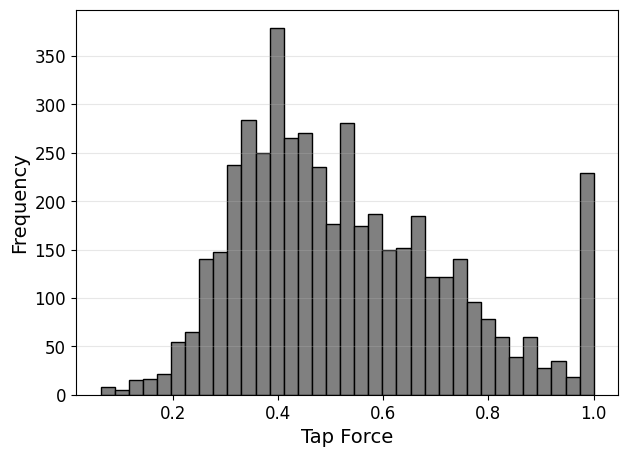

In [47]:
## histograms of data ##
fig,(ax1)=plt.subplots(figsize=(7,5))
hist = tap_data_clean[tap_data_clean>0.05]
print(hist.shape)
ax1.hist(hist.ravel(), bins=35, color="gray", edgecolor='black')
#ax.grid(alpha=0.3, axis='y')
#ax.set_ylabel("Frequency", fontsize=14)
#ax.set_xlabel("Tap Force", fontsize=14)
#ax.tick_params(labelsize=12)
print(f"{len(tap_data_clean.ravel())-len(tap_data_clean[tap_data_clean>0.05])}")
#ax.hist(tap_data_clean.ravel(), bins=35, color="gray", edgecolor='black')
ax1.grid(alpha=0.3, axis='y')
ax1.set_ylabel("Frequency", fontsize=14)
ax1.set_xlabel("Tap Force", fontsize=14)
ax1.tick_params(labelsize=12)
plt.show()

0.18054872047244094


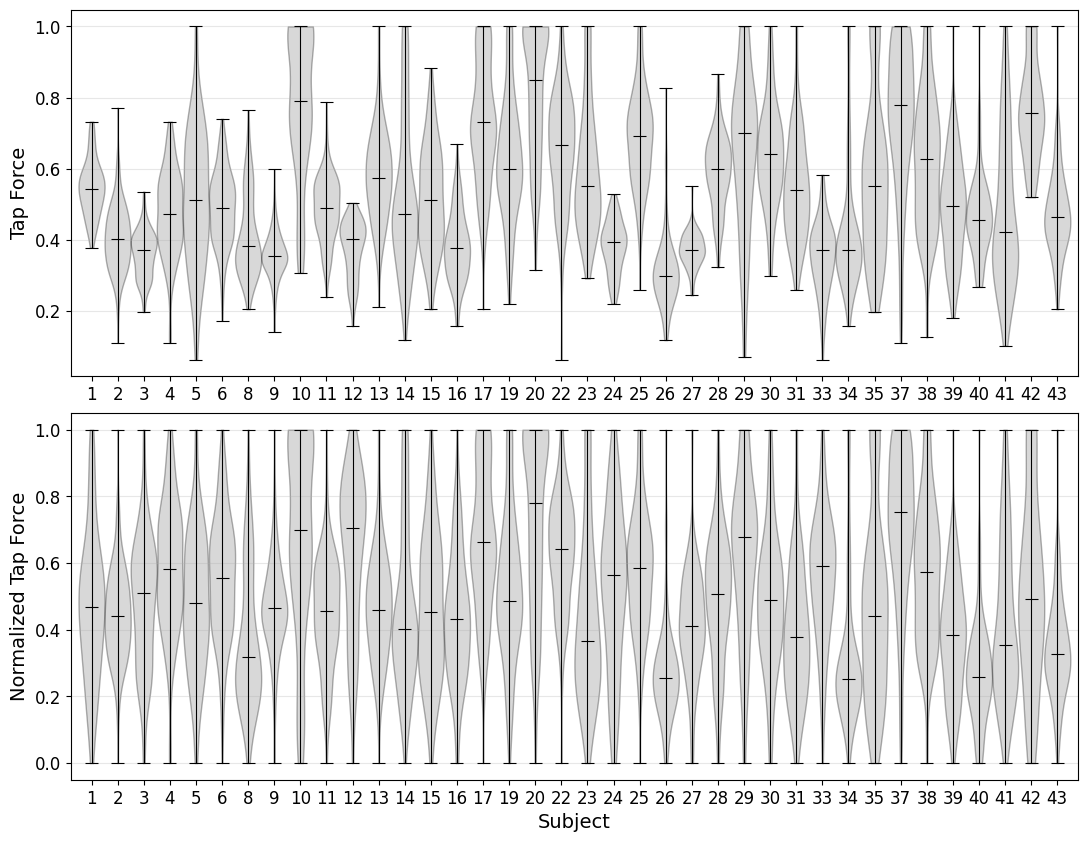

In [48]:
fig,(ax, ax1)=plt.subplots(2,1, figsize=(13,10))
fig.subplots_adjust(hspace=0.1)

index = np.arange(len(tap_data_clean))+1
graph=np.array([[0.0 for x in range(256)] for y in range(len(tap_data_clean))], dtype=float)
for i in range(len(tap_data_clean)):
    graph[i] = tap_data_clean[i].ravel()
print(np.mean(graph[i]))
top=[]
bottom=[]
for subj,data in enumerate(graph):
    _graph=data[data>0.05]
    _graph_norm=((_graph-np.min(_graph)) / (np.max(_graph)-np.min(_graph)))
    violin = ax.violinplot([_graph],positions=[subj+1], showmedians=True, widths=1.0, vert=True)
    #plt.setp(plt.gca().get_xticklabels(), visible=False)
    violin2 = ax1.violinplot([_graph_norm],positions=[subj+1], showmedians=True, widths=1.0, vert=True)
    #plt.setp(plt.gca().get_xticklabels(), visible=False)
    for v in violin['bodies']:
        v.set_facecolor('grey')
        v.set_edgecolor('black')
    for v in violin2['bodies']:
        v.set_facecolor('grey')
        v.set_edgecolor('black')    
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = violin[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(0.8)
        vp.set_alpha(1)
        vp = violin2[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(0.8)
        vp.set_alpha(1)

    top.append(_graph)
    bottom.append(_graph_norm)
top = list(chain(*top))
top=np.array(top, dtype=float)
bottom = list(chain(*bottom))
bottom=np.array(bottom, dtype=float)

index=np.arange(n_clean)+1
ax.set_xticks(index)
ax.set_xticklabels(clean_subject_indicies+1)
ax.set_xlim([0.2,38.8])
ax.grid(alpha=0.3, axis='y')
ax.set_ylabel("Tap Force", fontsize=14)
ax.tick_params(labelsize=12)

ax1.set_xticks(index)
ax1.set_xticklabels(clean_subject_indicies+1)
ax1.set_xlim([0.2,38.8])
ax1.grid(alpha=0.3, axis='y')
ax1.set_ylabel("Normalized Tap Force", fontsize=14)
ax1.set_xlabel("Subject", fontsize=14)
ax1.tick_params(labelsize=12)
plt.show()

(38, 16, 16)
(38, 256)
(256,)
0.06920845419933692
[0.1415778  0.15281217 0.12977803 0.         0.15000725 0.16057649
 0.06598386 0.17484478 0.12882189 0.14285678 0.15597612 0.16585154
 0.09689574 0.15104774 0.13490689 0.13286493 0.14215218 0.13307419
 0.10820592 0.08708496 0.1316146  0.14657172 0.16002785 0.11210125
 0.15779134 0.16016266 0.15521699 0.11866615 0.12032898 0.08564421
 0.12993667 0.0954509  0.12250714 0.05850979 0.13423593 0.1487742
 0.08524779 0.10703884 0.12852959 0.05208425 0.08355038]


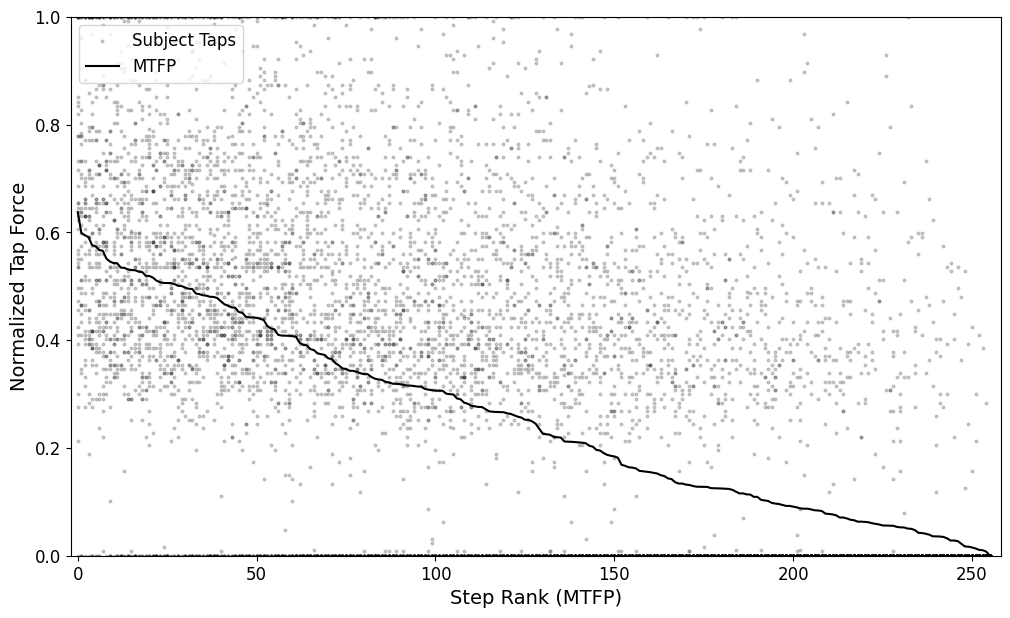

In [75]:
## Graph all taps on steps ordered by MTFP / Normalize taps for analysis ##
print(tap_data_clean.shape)
_tap_data_clean=tap_data_clean.copy()
#tap_data_clean=((_tap_data_clean-np.min(_tap_data_clean)) / (np.max(_tap_data_clean)-np.min(_tap_data_clean)))
mtfp = ([0.0 for y in range(256)]) #mean tapped force profile
clean=[]
for n in range(len(tap_data_clean)):
    clean.append(tap_data_clean[n].ravel())
_clean=np.array(clean,dtype=float)
print(_clean.shape)
mtfp=np.mean(_clean, axis=0)
print(mtfp.shape)

sd=[]
fig,(ax) = plt.subplots(figsize=(12,7))
sort = np.argsort(mtfp)[::-1]
clean=[]
for m in range(n_clean):
    line=_clean[m]
    clean.append(line[sort])
clean=np.array(clean,dtype=float)
error=[]
mtfp_sorted = mtfp[sort]
for n in range(len(mtfp)):
    res = clean[:,n]
    hold=np.full(res.shape[0],mtfp_sorted[n])
    error.append(np.abs(hold-res))
    idx = np.full(n_clean,n)
    sd.append(np.std(res))
    p = ax.scatter(idx,res, marker='.', alpha=0.18, color='black')
    p.set_sizes([15])

sd = np.array(sd, dtype=float)
error = np.std(error, axis=1)
print(mtfp[sort][215])
print(error[sort][215:])
#line2, = ax.plot(mtfp[sort]+error, color='grey', linestyle="--", label="+error")
#line1, = ax.plot(mtfp[sort]-error, color='grey', linestyle="--", label="-error")
line, = ax.plot(mtfp[sort], color='black', label="MTFP")
#line1, = ax.plot(mtfp[sort]+sd, color='black', linestyle="--",label="")
#line2, = ax.plot(mtfp[sort]-sd, color='black', linestyle="--",label="")

ax.tick_params(labelsize=12)
ax.set_ylim([0,1.0])
ax.set_xlim(-2,258)
ax.set_xlabel("Step Rank (MTFP)", fontsize=14)
ax.set_ylabel("Normalized Tap Force", fontsize=14)
ax.legend([p,line], ["Subject Taps","MTFP"], loc="upper left", ncols=1, fontsize="large")
#ax.legend([p,line,line1], ["Subject Taps","MTFP","MTFP+Error/-Error"], loc="upper left", ncols=1, fontsize="large")
plt.show()


(38, 16, 16) (256,)
(16,)


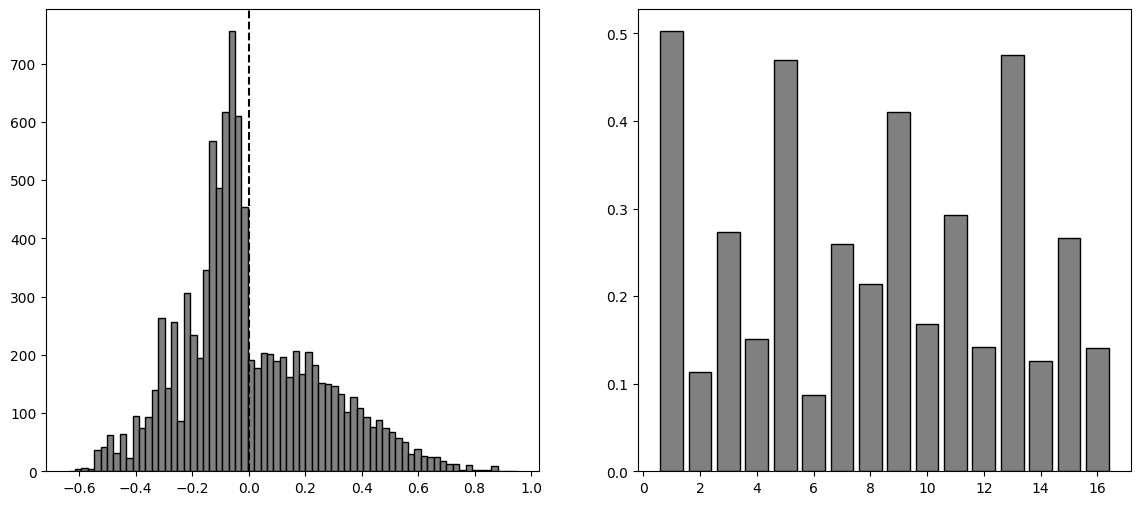

In [50]:
print(f"{tap_data_clean.shape} {mtfp.shape}")

subject_mae = []
stepwise=[]
for n in range(len(tap_data_clean)):
    rvl = tap_data_clean[n].ravel()
    _rvl = rvl-mtfp
    subject_mae.append(_rvl)
    for m in range(16):
        stepwise.append(tap_data_clean[n][m])
subject_mae=np.array(subject_mae, dtype=float)
stepwise=np.array(stepwise, dtype=float)
stepwise = np.mean(stepwise, axis=0)
print(stepwise.shape)

fig, (ax,ax1) = plt.subplots(1,2,figsize=(14,6))

ax.hist(subject_mae.ravel(), bins=70, color="gray", edgecolor='black')
ax.axvline(x=0, color='black', linestyle="--")


ax1.bar(np.arange(16)+1,stepwise, color="gray", edgecolor='black')
plt.show()

(38, 16, 16)
(38, 16)
(38, 16, 16)
13 1


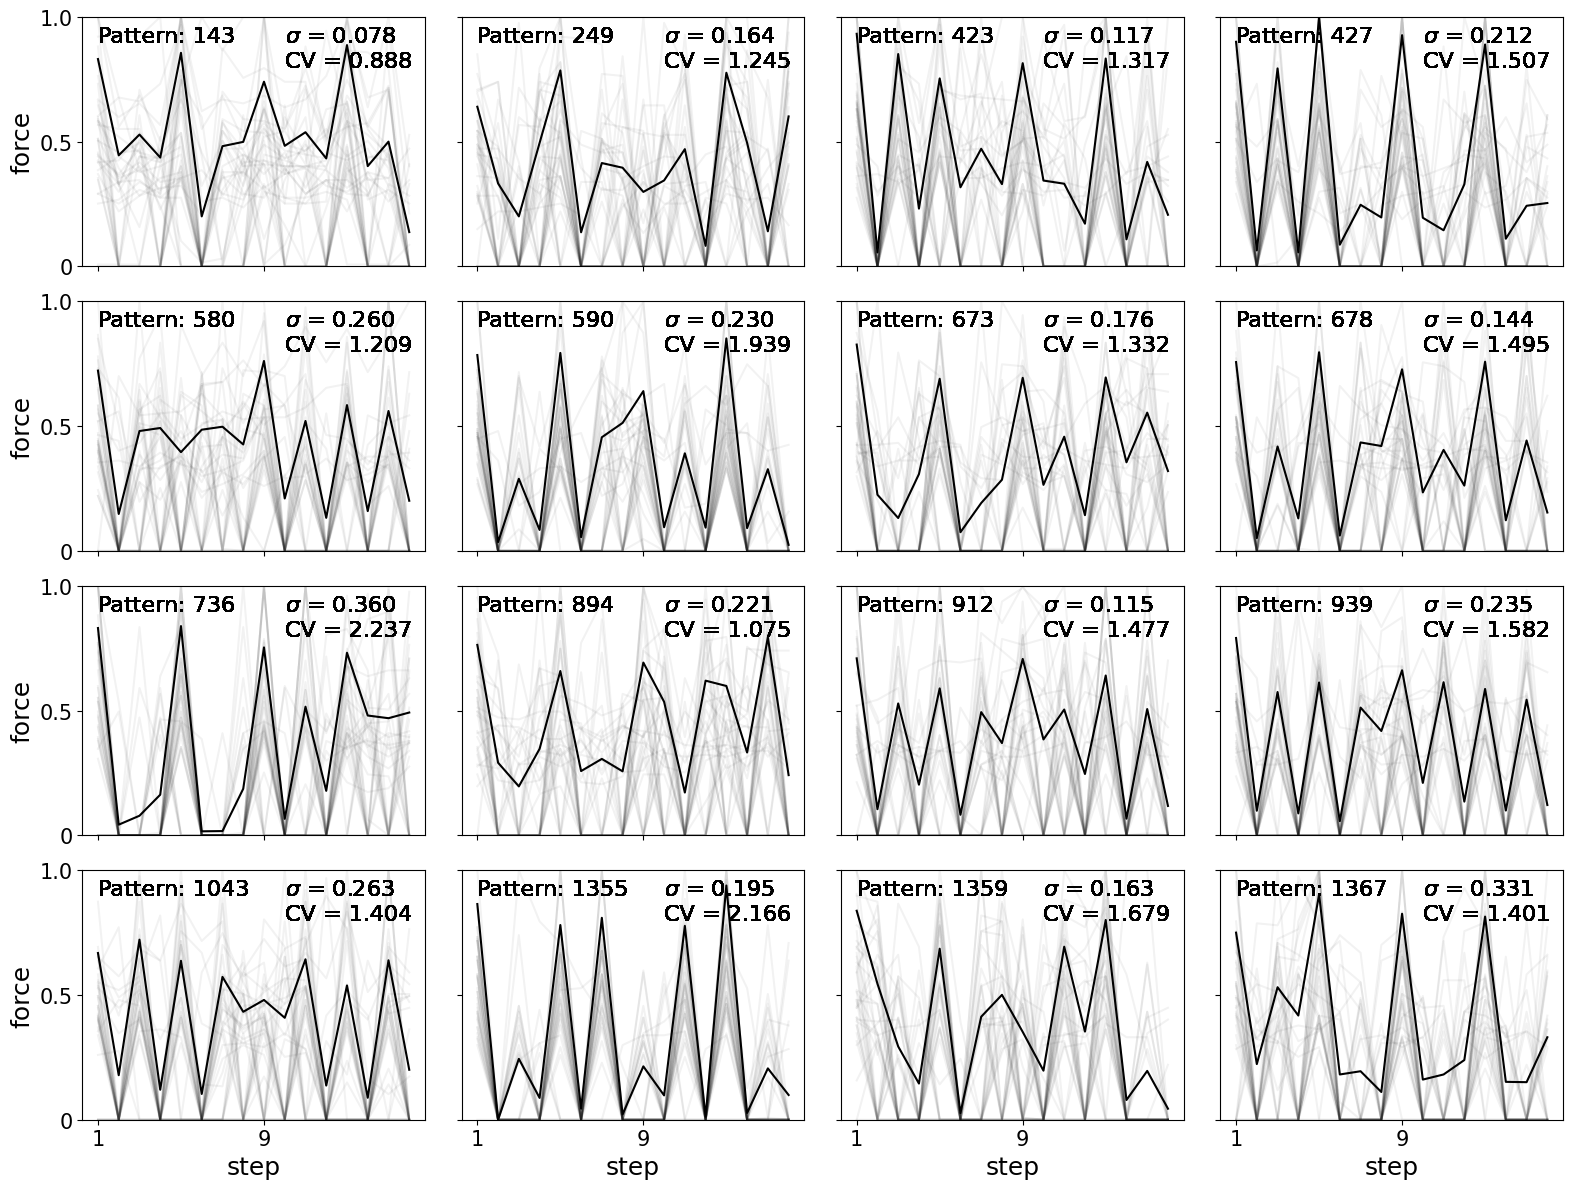

In [51]:
fig, axs = plt.subplots(4,4, figsize=(16,12))
index = np.arange(16)+1
print(tap_data_clean[:].shape)
print(tap_data_clean[:,1].shape)
_mtfp = mtfp.reshape(16,16)
step_sd = np.array([0.0 for x in range(16)])
ordered_index = np.argsort(test_patterns_indices)
tap_num_order = tap_data_clean[:,ordered_index,:]
_mtfp = _mtfp[ordered_index]
print(tap_num_order.shape)
tap_num_order = np.array(tap_num_order)

# Get correct order
temp = np.array([[0.0 for x in range(16)] for y in range(16)], dtype=float)
for subj in range(n_clean):
    temp += tap_data_clean[subj]
temp /= n_clean
_temp = temp[ordered_index]
mtfp = _temp

# Normalize
mtfp = mtfp / (np.max(mtfp)-np.min(mtfp))

for i in range(len(test_patterns_indices)):
    j = i//4

    sd = np.mean(np.std(tap_num_order[:][i], axis=0))
    step_sd += np.std(tap_num_order[:,i], axis=0)
    var = np.mean(np.var(tap_num_order[:,i], axis=0))
    mean = np.mean(np.mean(tap_num_order[:,i], axis=0))
    h = np.mean(tap_num_order[:,i], axis=0)
    if np.any(h<0.005):
        loc = np.where(h<0.005)[0][0]
        print(f"{i} {np.where(h<0.005)[0][0]}")
        h[loc]=1.0
        
    cv= np.std(tap_num_order[:,i], axis=0)/h
    #h = np.mean(tap_num_order[:,i], axis=0)

    #else np.zeros(16)
    for n in range(n_clean):
        #axs[j,i%4].plot(index,np.std(tap_num_order[:,i], axis=0), color='red')
        axs[j,i%4].plot(index, tap_num_order[n][i], alpha=0.05,color="black")
        axs[j,i%4].text(10,0.9,fr"$\sigma$ = {sd:.3f}", fontsize=16, alpha=0.8)
        axs[j,i%4].text(10,0.8,fr"CV = {np.mean(cv):.3f}", fontsize=16, alpha=0.8)
        axs[j,i%4].text(1,0.9, f"Pattern: {str(test_patterns_indices[ordered_index][i])[:-2]}",fontsize=16, alpha=0.8)
        
        axs[j,i%4].set_ylim([0,1])
        axs[j,i%4].set_xticks([1,9])
        axs[j,i%4].set_xticklabels(["1","9"])
        axs[j,i%4].set_yticks([0,0.5,1])
        axs[j,i%4].set_yticklabels(["0","0.5","1.0"])
        axs[j,i%4].tick_params(labelsize=15)
        
    #print(f"(Coeff.Var)={sd/mean:.3f} sd={sd:.3f} for patt {test_patterns_indices[i]}")
    axs[j,i%4].plot(index, mtfp[i], color='black', linewidth=1.5)

    if not i%4==0:
        axs[j][i%4].tick_params(labelleft=False)
    else:
        axs[j,i%4].set_ylabel("force", fontsize=18)
    if i<12:
        axs[j][i%4].tick_params(labelbottom=False)
    else:
        axs[j][i%4].set_xlabel("step",fontsize=18)

#print(tap_num_order[:,13])
fig.tight_layout()
plt.show()


In [52]:
music_data = [
    [1.50, 0.00, 0.00, 0.50, 0.500],
    [1.50, 0.50, 0.50, 1.50, 0.833],
    [4.50, 4.50, 4.50, 3.00, 4.500],
    [4.50, 1.50, 1.50, 4.50, 2.500],
    [3.00, 0.00, 0.00, 4.50, 1.000],
    [1.50, 3.00, 0.50, 0.50, 1.667],
    [4.50, 4.50, 4.50, 3.00, 4.500],
    [4.50, 4.50, 4.50, 4.50, 4.500],
    [0.50, 0.00, 0.50, 4.50, 0.333],
    [4.50, 4.50, 4.50, 3.00, 4.500],
    [3.00, 3.00, 0.00, 0.50, 2.000],
    [4.50, 4.50, 4.50, 1.50, 4.500],
    [4.50, 1.50, 4.50, 3.00, 3.500],
    [4.50, 4.50, 4.50, 4.50, 4.500],
    [4.50, 3.00, 4.50, 3.00, 4.000],
    [4.50, 4.50, 0.00, 0.50, 3.000],
    [4.50, 3.00, 3.00, 3.00, 3.500],
    [4.50, 4.50, 4.50, 1.50, 4.500],
    [4.50, 4.50, 4.50, 0.00, 4.500],
    [3.00, 4.50, 0.50, 0.00, 2.667],
    [4.50, 4.50, 4.50, 4.50, 4.500],
    [4.50, 4.50, 4.50, 4.50, 4.500],
    [0.50, 0.00, 0.00, 3.00, 0.167],
    [4.50, 4.50, 4.50, 1.50, 4.500],
    [1.50, 0.00, 0.00, 1.50, 0.500],
    [4.50, 1.50, 1.50, 3.00, 2.500],
    [4.50, 0.50, 3.00, 1.50, 2.667],
    [4.50, 4.50, 4.50, 3.00, 4.500],
    [4.50, 0.00, 3.00, 3.00, 2.500],
    [4.50, 0.50, 4.50, 3.00, 3.167],
    [4.50, 4.50, 4.50, 1.50, 4.500],
    [4.50, 3.00, 0.00, 0.50, 2.500],
    [4.50, 3.00, 1.50, 0.50, 3.000],
    [4.50, 3.00, 3.00, 1.50, 3.500],
    [4.50, 4.50, 1.50, 4.00, 3.500],
    [4.50, 4.50, 4.50, 3.00, 4.500],
    [4.50, 4.50, 3.00, 1.50, 4.000],
    [4.50, 3.00, 4.50, 1.50, 4.000],
    [4.50, 4.50, 4.50, 1.50, 4.500],
    [4.50, 4.50, 4.50, 3.00, 4.500],
    [4.50, 0.00, 3.00, 0.50, 2.500],
    [4.50, 4.50, 4.50, 4.50, 4.500],
    [4.50, 4.50, 4.50, 3.00, 4.500]
]


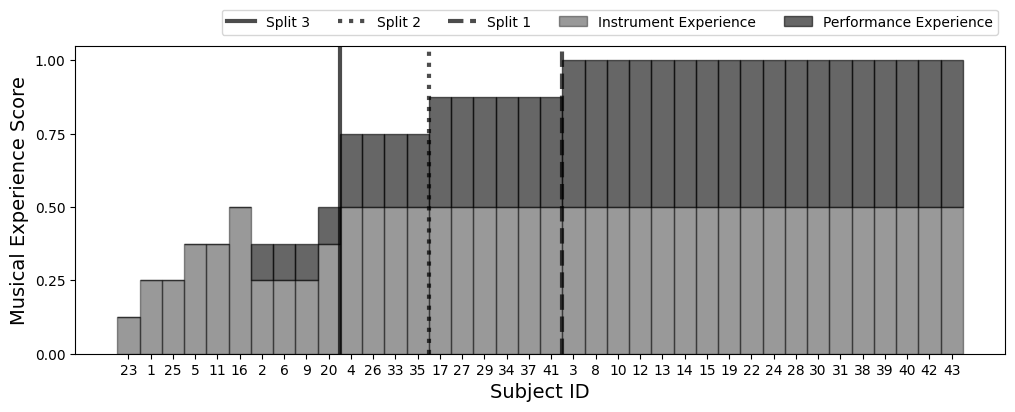

In [53]:
## Test group separations ##
data = [
    [2, 0, 0, 1],
    [2, 1, 1, 2],
    [4, 4, 4, 3],
    [4, 2, 2, 4],
    [3, 0, 0, 4],
    [2, 3, 1, 1],
    [4, 4, 4, 3],
    [4, 4, 4, 4],
    [2, 0, 1, 4],
    [4, 4, 4, 3],
    [3, 3, 0, 1],
    [4, 4, 4, 2],
    [4, 2, 4, 3],
    [4, 4, 4, 4],
    [4, 3, 4, 3],
    [4, 4, 0, 1],
    [4, 3, 3, 3],
    [4, 4, 4, 2],
    [4, 4, 4, 0],
    [3, 4, 1, 0],
    [4, 4, 4, 4],
    [4, 4, 4, 4],
    [1, 0, 0, 3],
    [4, 4, 4, 2],
    [2, 0, 0, 2],
    [4, 2, 2, 3],
    [4, 1, 3, 2],
    [4, 4, 4, 3],
    [4, 0, 3, 3],
    [4, 1, 4, 3],
    [4, 4, 4, 2],
    [4, 3, 0, 1],
    [4, 3, 2, 1],
    [4, 3, 3, 2],
    [4, 4, 2, 4],
    [4, 4, 4, 3],
    [4, 4, 3, 2],
    [4, 3, 4, 2],
    [4, 4, 4, 2],
    [4, 4, 4, 3],
    [4, 0, 3, 1],
    [4, 4, 4, 4],
    [4, 4, 4, 3]
]
fig, ax=plt.subplots(figsize=(12,4))
clean_data = []
for i in range(len(clean_subject_indicies)):
    clean_data.append([data[clean_subject_indicies[i]][0],data[clean_subject_indicies[i]][2],clean_subject_indicies[i]])
num = n_clean

data=np.array(clean_data, dtype=int)

data=np.delete(data, 2, axis=1)
_exp = np.argsort(np.sum(data, axis=1))
_exp = np.argsort(data[:,0])
_exp=np.lexsort((np.sum(data[:,:], axis=1), data[:,1]))
data=data[_exp]
alphs=[0.4,0.6]
bx = []
lbl = ["Instrument Experience", "Performance Experience"]
for s in range(num):
    bottom=0.0
    for i in range(2):
    #for i in range(3,0,-1):
        bx.append(ax.bar((s*2)-1, data[s][i], color='black', alpha=alphs[i], label=f"{lbl[i]}", width=2, bottom=bottom, edgecolor="black"))
        bottom += data[s][i]
        if i==2:
            ax.text((s*2)-1, bottom+0.02,f"{np.mean(data[s][:3]/4):.2f}", rotation='vertical', va='bottom')
    #ax.bar(s*2, np.mean(data[s]), color='grey', alpha=0.5, width=.8, hatch='/', edgecolor="black")
ax.set_xticks((np.arange(num)*2)-1)
subjs=(np.arange(num))[_exp]
subjs=clean_subject_indicies[_exp]

ax.set_xticklabels([f"{s+1}" for s in subjs])
ax.set_yticks([0,2,4,6,8])
ax.set_yticklabels([f"{z/8:.2f}" for z in [0,2,4,6,8]])
ax.set_xlabel("Subject ID",fontsize=14)
ax.set_ylabel("Musical Experience Score",fontsize=14)
ax1.scatter(np.arange(num),np.mean(data[:,:], axis=1)/4)

sp1=ax.axvline(x=(n_subjects//2-2)*2, linestyle="--", color='black', alpha=0.7, linewidth=3)
sp2=ax.axvline(x=26, linestyle=":", color='black', alpha=0.7, linewidth=3)
sp3=ax.axvline(x=18, linestyle="-", color='black', alpha=0.7, linewidth=3)

ax.legend([sp3, sp2, sp1, bx[0], bx[1]],["Split 3", "Split 2", "Split 1", "Instrument Experience", "Performance Experience"], bbox_to_anchor=[1,1.14], ncols=5)
#ax1.axhline(y=np.mean(np.mean(data[:,:], axis=1)/4), linestyle=":", color='black')
plt.show()

In [54]:
subj_nomusic=[]
nomusic_idx=[]
subj_music=[]
music_idx=[]
questions=["play_music", "study_music", "perform", "interaction"]

# 8 is 50/50, 7 is mean musical value, and 6 is true lower higher (28h/10l)
music_value_split = 8  

for i in range(n_clean):
    #if float(data[i][0])<3.1:
    clean_data=np.array(clean_data)
    if np.sum(clean_data[i][:2])<music_value_split:
        subj_nomusic.append(i)
        nomusic_idx.append(clean_data[i][2])
    else: 
        subj_music.append(i)
        music_idx.append(clean_data[i][2])
subj_music = np.array(subj_music)
subj_nomusic = np.array(subj_nomusic)
nomusic_idx = np.array(nomusic_idx, dtype=int)
music_idx=np.array(music_idx, dtype=int)
print(f" {len(subj_music)} {len(subj_nomusic)}")
print(f"{len(subj_nomusic)/n_subjects:.2f}")
print(f"{outliers}")
#print(f"{subj_nomusic}")
print(f"Low: {nomusic_idx+1} actual - nomusic_idx")
print(f"---: {subj_nomusic} clean - subj_nomusic")
print(f"High: {music_idx+1} actual - music_idx")
print(f"----: {subj_music} clean - subj_music")

print(clean_subject_indicies)

 18 20
0.47
[6, 17, 20, 31, 35]
Low: [ 1  2  4  5  6  9 11 16 17 20 23 25 26 27 29 33 34 35 37 41] actual - nomusic_idx
---: [ 0  1  3  4  5  7  9 14 15 17 19 21 22 23 25 28 29 30 31 35] clean - subj_nomusic
High: [ 3  8 10 12 13 14 15 19 22 24 28 30 31 38 39 40 42 43] actual - music_idx
----: [ 2  6  8 10 11 12 13 16 18 20 24 26 27 32 33 34 36 37] clean - subj_music
[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 18 19 21 22 23 24 25 26
 27 28 29 30 32 33 34 36 37 38 39 40 41 42]


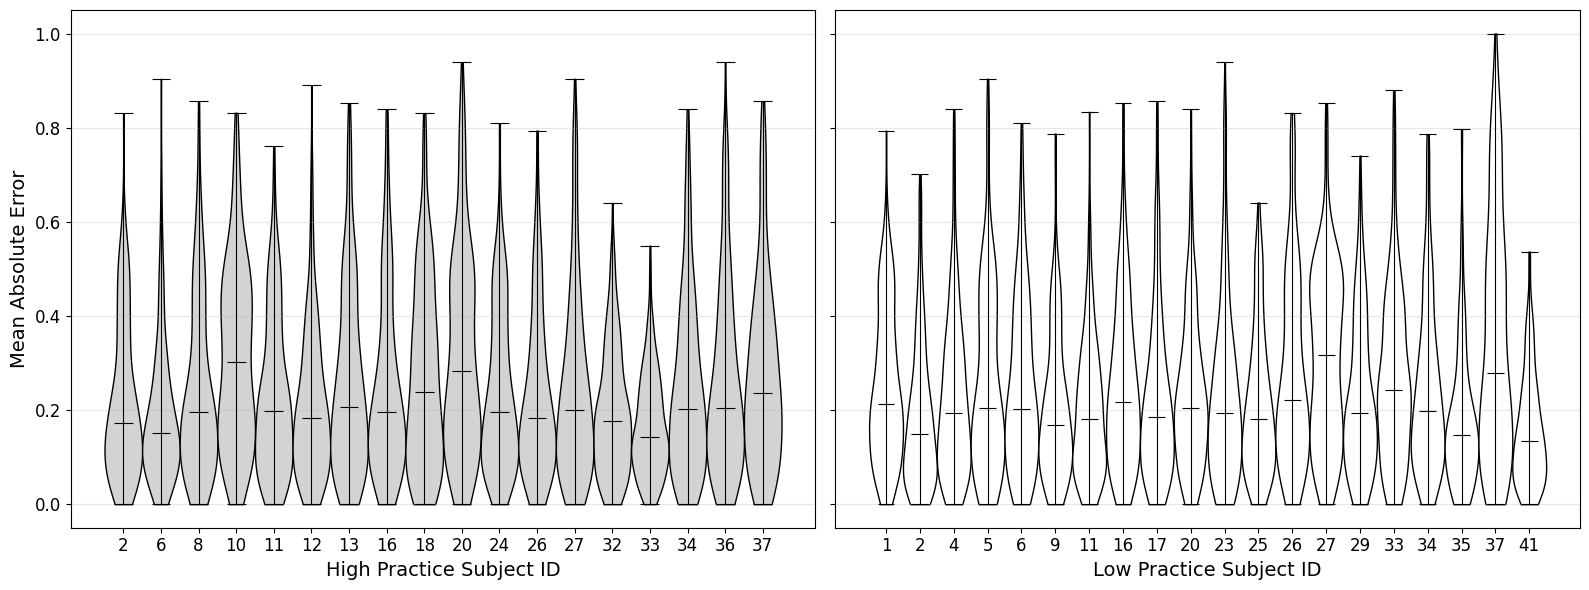

0.243 0.238
0.177 0.172


In [55]:
fig,(ax, ax1)=plt.subplots(1,2, figsize=(16,6),sharey=True)
#gridspec_kw={'width_ratios': [(n_subjects/len(subj_music)/(n_subjects/len(subj_nomusic))),1]})

n=0
music = []
nomusic = []
for i in subj_music:
    tmp = tap_data_clean[i]
    v = tmp[ordered_index].ravel()
    _v = np.abs(mtfp.ravel()-v)
    #_v = v[v>0.05]
    violin = ax.violinplot([_v],positions=[n], showmedians=True, widths=1.0, vert=True)
    n+=1
    for v in violin['bodies']:
        v.set_facecolor('lightgrey')
        v.set_edgecolor('black')
        v.set_linewidth(1)
        v.set_alpha(1)   
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        violin[partname].set_edgecolor('black')
        violin[partname].set_linewidth(0.8)
        violin[partname].set_alpha(1)
    music.append(_v)

n=0

for j in subj_nomusic:
    tmp = tap_data_clean[j]
    v = tmp[ordered_index].ravel()
    _v = np.abs(mtfp.ravel()-v)
    #_v = v[v>0.05]
    violin2 = ax1.violinplot([_v],positions=[n], showmedians=True, widths=1.0, vert=True)
    n+=1
    for v in violin2['bodies']:
        v.set_facecolor('white')
        v.set_edgecolor('black')
        v.set_linewidth(1)
        v.set_alpha(1)   
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        violin2[partname].set_edgecolor('black')
        violin2[partname].set_linewidth(0.8)
        violin2[partname].set_alpha(1)
    nomusic.append(_v)

music=np.array(music, dtype=float)
nomusic=np.array(nomusic, dtype=float)

index=np.arange(len(subj_music))
ax.set_xticks(index)

#ax.set_xticklabels(music_idx+1)
ax.set_xticklabels(subj_music)
ax.grid(alpha=0.3, axis='y')
ax.set_ylabel("Mean Absolute Error", fontsize=14)
ax.set_xlabel("High Practice Subject ID", fontsize=14)
ax.tick_params(labelsize=12)

index=np.arange(len(subj_nomusic))
ax1.set_xticks(index)

#ax1.set_xticklabels(subj_nomusic)
ax1.set_xticklabels(nomusic_idx+1)
ax1.grid(alpha=0.3, axis='y')
#ax1.set_ylabel("Normalized Tap Force", fontsize=14)
ax1.set_xlabel("Low Practice Subject ID", fontsize=14)
ax1.tick_params(labelsize=12)

fig.tight_layout()
plt.show()

cv_music = np.std(music, axis=1)/np.mean(music, axis=1)
cv_nomusic = np.std(nomusic, axis=1)/np.mean(nomusic, axis=1)
print(f"{np.mean(np.mean(music, axis=1)):.3f} {np.mean(np.mean(nomusic, axis=1)):.3f}")
print(f"{np.mean(np.std(music, axis=1)):.3f} {np.mean(np.std(nomusic, axis=1)):.3f}")

In [56]:
## Welch's t-test and Tukey's on Mean Abs Error ##
t_stat, p_val = stats.ttest_ind(music.ravel(),nomusic.ravel(),  equal_var=False)
print(f"{t_stat:.3f} {p_val:.8f}")

tests_in_order = np.concatenate((music.ravel(), nomusic.ravel()), axis=0)

labels = ["highmusic"]*(len(music)*256) + ["lowmusic"]*(len(nomusic)*256)
data = {'error':tests_in_order.ravel(), 'test_type':labels}
data_df = pd.DataFrame(data)

tukey = pairwise_tukeyhsd(data_df['error'], data_df['test_type'], alpha=0.05)
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
print(f"Tap Consistency Tukey's HSD Results: \n{tukey_df}\n")

1.387 0.16548452
Tap Consistency Tukey's HSD Results: 
      group1    group2  meandiff  p-adj   lower   upper  reject
0  highmusic  lowmusic   -0.0051  0.165 -0.0123  0.0021   False



In [67]:
## Welch's t-test and Tukey's on Coeff Var of Abs Error (not used) ##
t_stat, p_val = stats.ttest_ind(cv_music.ravel(), cv_nomusic.ravel(), equal_var=False)
print(f"{t_stat:.3f} {p_val:.8f}")

tests_in_order = np.concatenate((cv_music.ravel(), cv_nomusic.ravel()), axis=0)

labels = ["highmusic"]*(len(cv_music)) + ["lowmusic"]*(len(cv_nomusic))
data = {'error':tests_in_order.ravel(), 'test_type':labels}
data_df = pd.DataFrame(data)

tukey = pairwise_tukeyhsd(data_df['error'], data_df['test_type'], alpha=0.05)
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
print(f"Tap Consistency Tukey's HSD Results: \n{tukey_df}\n")

0.049 0.96125460
Tap Consistency Tukey's HSD Results: 
      group1    group2  meandiff   p-adj   lower   upper  reject
0  highmusic  lowmusic   -0.0008  0.9616 -0.0361  0.0344   False



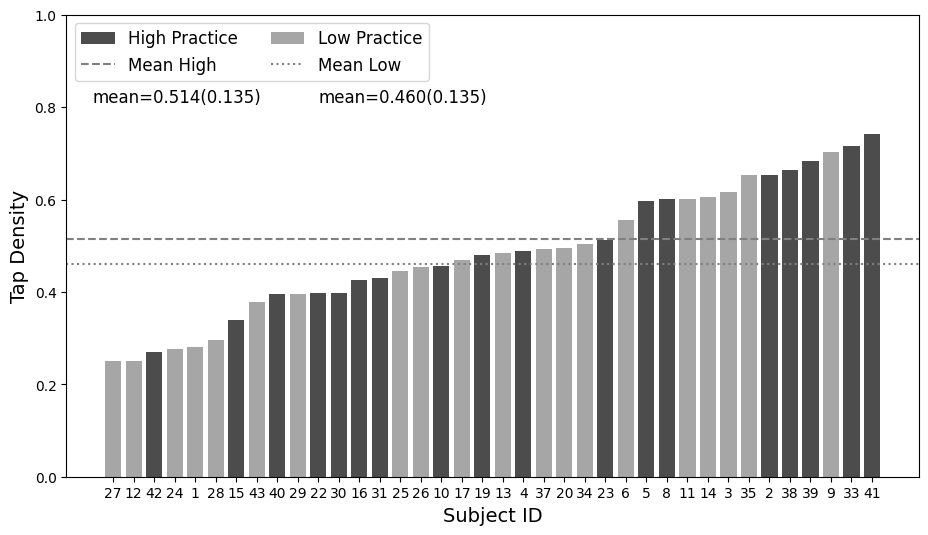

1.185 0.24371193
Tap Consistency Tukey's HSD Results: 
      group1    group2  meandiff   p-adj   lower   upper  reject
0  highmusic  lowmusic   -0.0535  0.2436 -0.1451  0.0381   False



In [69]:
## Graph tap density for both groups + Welch's t and Tukeys ##
fig, ax = plt.subplots(figsize=(11,6))
subjidx=np.arange(n_clean)
tdc=[]
for i in range(n_clean):
    count=0
    for j in range(16):
        for k in range(16):
            count += 1 if tap_data_clean[i][j][k]>0.05 else 0
    tdc.append(count)
tdc=np.array(tdc, dtype=float)
_order = np.argsort(tdc)
_tdc=tdc[_order]
clean_index=clean_subject_indicies[_order]+1
subj_nomusic2=[]
nomusic_idx=[]
subj_music2=[]
music_idx=[]
questions=["play_music", "study_music", "perform", "interaction"]
data=[music_data[idx] for idx in clean_subject_indicies]
data=np.array(data)

# rearrange + reassign idx
data=data[_order]
for i in range(len(data)):
    #if float(data[i][0])<3.1:
    if float(data[i][0]+data[i][2])<8:
        subj_nomusic2.append(i)
    else: 
        subj_music2.append(i)
        
mean_high=np.mean(_tdc[subj_music]/256)
mean_low=np.mean(_tdc[subj_nomusic]/256)
m1=ax.axhline(mean_high, linestyle="--", color="grey") # mean high
m2=ax.axhline(mean_low, linestyle=":", color="grey") # mean high
subj_music2=subj_music
subj_nomusic2=subj_nomusic
for x in range(len(subj_music2)):
    p=ax.bar(subj_music2[x],_tdc[subj_music2[x]]/256, color='black', alpha=0.7)
for x in range(len(subj_nomusic2)):
    p2= ax.bar(subj_nomusic2[x],_tdc[subj_nomusic2[x]]/256, color='grey', alpha=0.7)
ax.set_xticks(subjidx)
ax.set_ylim([0,1.0])
#ax.set_xticklabels(subjidx[_order])
ax.set_xticklabels(clean_index)
ax.set_xlabel("Subject ID", fontsize=14)
ax.set_ylabel("Tap Density", fontsize=14)
ax.tick_params(axis="x",labelsize=10)
ax.legend([p, m1, p2, m2], ["High Practice", "Mean High", "Low Practice", "Mean Low"], loc='upper left', fontsize='large',ncols=2)
ax.text(-1,0.81,f"mean={np.mean(_tdc[subj_music2]/256):.3f}({np.std(_tdc[subj_music2]/256):.3f})", fontsize=12)
ax.text(10,0.81,f"mean={np.mean(_tdc[subj_nomusic2]/256):.3f}({np.std(_tdc[subj_nomusic2]/256):.3f})", fontsize=12)
plt.show()


t_stat, p_val = stats.ttest_ind(_tdc[subj_music2].ravel()/256, _tdc[subj_nomusic2].ravel()/256, equal_var=False)
print(f"{t_stat:.3f} {p_val:.8f}")
_music = _tdc[subj_music2].ravel()/256
_nomusic = _tdc[subj_nomusic2].ravel()/256
tests_in_order = np.concatenate((_music.ravel(), _nomusic.ravel()), axis=0)

labels = ["highmusic"]*(len(_music)) + ["lowmusic"]*(len(_nomusic))
data = {'error':tests_in_order.ravel(), 'test_type':labels}
data_df = pd.DataFrame(data)

tukey = pairwise_tukeyhsd(data_df['error'], data_df['test_type'], alpha=0.05)
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
print(f"Tap Consistency Tukey's HSD Results: \n{tukey_df}\n")

high=tdc[_order][subj_music].ravel()/256
low=tdc[_order][subj_nomusic].ravel()/256


(38, 16, 16)
[ 0  1  3  4  5  8 10 15 16 19 22 24 25 26 28 32 33 34 36 40]


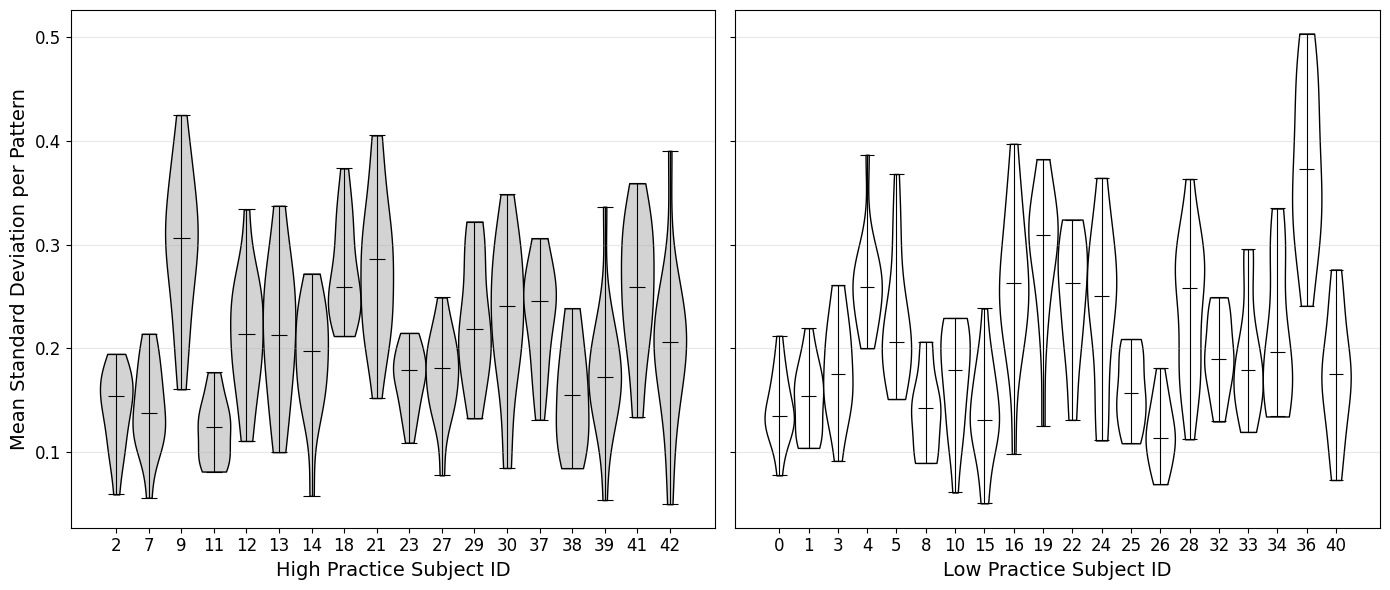

In [70]:
## Graph mean std dev pattern-wise for both groups ##
fig,(ax, ax1)=plt.subplots(1,2, figsize=(14,6),sharey=True)
#gridspec_kw={'width_ratios': [2.5, 1]}
print(subject_mae.shape)
subject_mae=subject_mae.reshape(n_clean, 16, 16)
sd_music = []
for i in range(len(music)):
    sd_music.append(np.std(subject_mae[subj_music][i], axis=1))
sd_music=np.array(sd_music, dtype=float)

sd_nomusic = []
for i in range(len(nomusic)):
    sd_nomusic.append(np.std(subject_mae[subj_nomusic][i], axis=1))
sd_nomusic=np.array(sd_nomusic, dtype=float)

n=0
for i in range(len(subj_music)):
    _v = sd_music[i]
    violin = ax.violinplot([_v],positions=[n], showmedians=True, widths=1.0, vert=True)
    n+=1
    for v in violin['bodies']:
        v.set_facecolor('lightgrey')
        v.set_edgecolor('black')
        v.set_linewidth(1)
        v.set_alpha(1)   
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        violin[partname].set_edgecolor('black')
        violin[partname].set_linewidth(0.8)
        violin[partname].set_alpha(1)

n=0
for j in range(len(subj_nomusic)):
    _v = sd_nomusic[j]
    violin2 = ax1.violinplot([_v],positions=[n], showmedians=True, widths=1.0, vert=True)
    n+=1
    for v in violin2['bodies']:
        v.set_facecolor('white')
        v.set_edgecolor('black')
        v.set_linewidth(1)
        v.set_alpha(1)   
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        violin2[partname].set_edgecolor('black')
        violin2[partname].set_linewidth(0.8)
        violin2[partname].set_alpha(1)
print(clean_subject_indicies[subj_nomusic])
ax.set_xticks(np.arange(len(subj_music)))
ax.set_xticklabels(clean_subject_indicies[subj_music])
#ax.set_xticklabels([int(x)+1 for x in subj_music])
ax.grid(alpha=0.3, axis='y')
ax.set_ylabel("Mean Standard Deviation per Pattern", fontsize=14)
ax.set_xlabel("High Practice Subject ID", fontsize=14)
ax.tick_params(labelsize=12)
#ax.set_ylim([0,0.6])

#ax1.set_ylim([0,0.6])
ax1.grid(alpha=0.3, axis='y')
ax1.tick_params(labelsize=12)
ax1.set_xlabel("Low Practice Subject ID", fontsize=14)
ax1.set_xticks(np.arange(len(subj_nomusic)))
ax1.set_xticklabels(clean_subject_indicies[subj_nomusic])
fig.tight_layout()
plt.show()

In [60]:
## Lines -----------
dashed_line_style={
    'color':'dimgrey',
    'linestyle':'--',
    'alpha':0.8,
    'linewidth':0.8
}
solid_line_style={
    'color':'dimgrey',
    'linestyle':'-',
    'alpha':0.9,
    'linewidth':0.8
}
title_style={ 
    'fontsize':14,
    'fontfamily':'sans-serif',
    'fontweight':'book'
}

In [72]:
## Stats for flattened patterns ##
flatterns_f = open(os.getcwd()+"/data/flattened_patterns.pkl","rb")
_flatterns=pickle.load(flatterns_f)
flatterns_f.close()
flatterns_names = ['OnsetDen', 'OnsetDen_Meter', 'OnsetDen_Sync','OnsetDen_Sync_Meter',
              'FreqWeightOnsetDen', 'FreqWeightOnsetDen_Meter', 'FreqWeightOnsetDen_Sync','FreqWeightOnsetDen_Sync_Meter',
              'RelOnsetDen', 'RelOnsetDen_Meter', 'RelOnsetDen_Sync','RelOnsetDen_Sync_Meter',
              'Mono', 'Mono_Meter', 'Mono_Sync','Mono_Sync_Meter', 'Mono_PolySync']
print(_flatterns.shape)

# Extract flattened pattens
flatterns=np.array([[[0.0 for x in range(16)] for y in range(16)] for z in range(17)], dtype=float) #(testpatt, alg, steps)
patt_count=0
_new_index = np.array([894, 423, 1367, 249, 939, 427, 590, 143, 912, 580, 1043, 673, 1359, 736, 678, 1355], dtype=int)
new_index = _new_index[ordered_index]
for i in range(len(_flatterns)):
    if i in new_index:
        for alg in range(17):
            flatterns[alg][patt_count]=_flatterns[i][alg]
        patt_count+=1
flatterns = np.array(flatterns, dtype=float)
flat = np.array([x.ravel() for x in flatterns])
n_algs = flatterns.shape[0]
print(flatterns.shape)

# Get correct order
temp = np.array([[0.0 for x in range(16)] for y in range(16)], dtype=float)
for subj in range(n_clean):
    temp += tap_data_clean[subj]
temp /= n_clean
_temp = temp[ordered_index]
mtfp = _temp.ravel()

# Normalize
mtfp = mtfp / (np.max(mtfp)-np.min(mtfp))

sort = np.argsort(mtfp)[::-1]
idx = np.arange(len(mtfp))+1
results_names = ['rho', 'p-val', 'MAE', 'MSE', 'RMSE', 'R2', 'AdjR2', 'DT', 'kNN', 'SVR', 'AIC', 'BIC', 'ERR', 'ERRSTD', 'MAESTD']
results = np.array([[0.0 for x in range(15)] for y in range(n_algs)], dtype=float) # 12 stat types

for i in range(n_algs):

    wcx, p_val = stats.pearsonr(mtfp[sort], flat[i][sort])
    results[i][0] = wcx
    results[i][1] = p_val
    txt = r'rho = {:.3f}, p_val = {:.3e}'.format(wcx, p_val)
    
    #print(f"{txt} ---- {flatterns_names[i]}")
    _meter=[4,0,1,0, 2,0,1,0, 3,0,1,0, 2,0,1,0]
    meter = _meter*16
    meter=np.array(meter, dtype=float)
    meter/=np.max(meter)
    results[i][2] = np.mean(np.abs(mtfp-flat[i])) 
    results[i][3] = np.mean(pow(mtfp-flat[i], 2))
    results[i][4] = np.sqrt(np.mean(pow(mtfp-flat[i], 2)))

    # R2
    model = OLS(mtfp, flat[i]).fit()
    k = len(model.params) # num coefficients
    n = len(flat[i])  # Number of data points
    sst = np.sum((mtfp-np.mean(mtfp))**2)
    sse = np.sum((mtfp - flat[i])**2)
    r2 = 1-(sse/sst)
    adj_r2 = (1 - (1-r2)*(n-1)) / (n-k-1)
    results[i][5] = r2
    results[i][6] = adj_r2

    # REGRESSIONS
    tru = mtfp.reshape(-1,1)
    fpi = flat[i].reshape(-1,1)

    kNN_model = KNeighborsRegressor()
    kNN_model.fit(tru, fpi)

    DT_model = DecisionTreeRegressor()
    DT_model.fit(tru, fpi)

    #svr_model = LinearSVR()
    #svr_wrap_model = MultiOutputRegressor(svr_model)
    #svr_wrap_model.fit(tru, fpi)

    cross_validation = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1) # 10-fol
    np.seterr("ignore")

    n_scores_DT = np.abs(cross_val_score(DT_model, tru, fpi, scoring='neg_mean_absolute_error', cv=cross_validation,n_jobs=-1))
    n_scores_kNN = np.abs(cross_val_score(kNN_model, tru, fpi, scoring='neg_mean_absolute_error', cv=cross_validation,n_jobs=-1))
    #n_scores_svr = np.abs(cross_val_score(svr_wrap_model, tru, fpi, scoring='neg_mean_absolute_error', cv=cross_validation,n_jobs=-1))

    results[i][7] = np.mean(n_scores_DT)
    results[i][8] = np.mean(n_scores_kNN)
    #results[i][9] = np.mean(n_scores_svr)

    # Calculate the likelihood (L) - For illustration, assuming normally distributed errors
    residuals = mtfp - flat[i]
    likelihood = np.prod(stats.norm.pdf(residuals))

    # Calculate AIC
    AIC = 2 * k - 2 * np.log(likelihood)
    
    # Calculate BIC
    BIC = n * np.mean(pow(mtfp-flat[i], 2)) + k * np.log(n)

    results[i][10] = AIC
    results[i][11] = BIC
    results[i][12] = np.mean(mtfp-flat[i])
    results[i][13] = np.std(mtfp-flat[i])
    results[i][14] = np.std(np.abs(mtfp-flat[i]))
    #if i > 10:
        #print(f"{i}")
        #print(f"ABS {np.mean(np.abs(mtfp-flat[i])):.3f} ({np.std(np.abs(mtfp-flat[i])):.3f})")
        #print(f"ERR {np.mean(mtfp-flat[i]):.3f} ({np.std(mtfp-flat[i]):.3f})")
        #print(f"MAE: {np.mean(np.abs(mtfp-flat[i])):.3f}")
        #print(f"MSE: {np.mean(pow(mtfp-flat[i], 2)):.3f}")
        #print(f"RMSE: {np.sqrt(np.mean(pow(mtfp-flat[i], 2))):.3f}")
        #print(f"R^2: {r2:.3f}")
        #print("Mean Abs Error[DT]: %.3f (%.3f)" % (np.mean(n_scores_DT), np.std(n_scores_DT)))
        #print("Mean Abs Error[kNN]: %.3f (%.3f)" % (np.mean(n_scores_kNN), np.std(n_scores_kNN)))
        #print("Mean Abs Error[SVR]: %.3f (%.3f)" % (np.mean(n_scores_svr), np.std(n_scores_svr)))    
        #print(f"Adj. R^2: {adj_r2:.3f}")
        #print(f"AIC: {AIC:.2f} - k={k}")
        #print(f"BIC: {BIC:.2f} - k={k}")
      
print(f"--rho     mae")
""" for j in range(17):
    print(f"{j+1} RHO {results[j][0]:.3f} MAE {results[j][2]:.3f} ({results[j][14]:.3f}) - {flatterns_names[j]}")
    #print(f"ERR {results[j][12]:.3f} ({results[j][13]:.3f})")
    print(*results[j])
    print() """
with open(os.getcwd()+"/data/flat_stats.csv",'w') as f:
    writer = csv.writer(f)                
    for i in range(len(results)):
        writer.writerow(results[i])

(1378, 17, 16)
(17, 16, 16)
--rho     mae


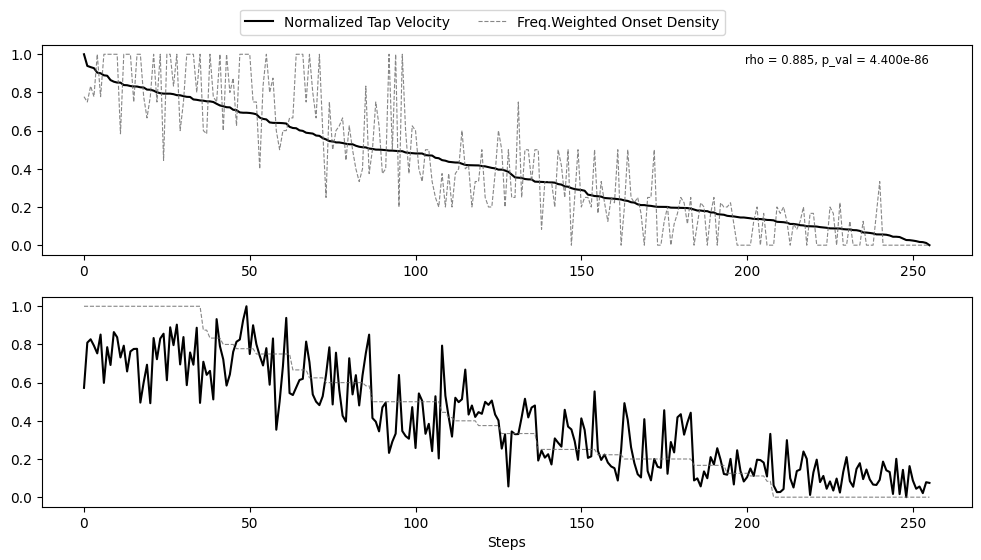

In [62]:
_graph=True
i=4
#rho, p_val = stats.pearsonr(mtfp[sort], meter[sort]) # basic meter
idx=np.arange(256)
rho, p_val = stats.pearsonr(mtfp[sort], flat[i][sort])
txt = r'rho = {:.3f}, p_val = {:.3e}'.format(rho, p_val)
if _graph:
    fig,(ax,ax1) = plt.subplots(2,1, figsize=(12,6))

    ax.plot(idx, mtfp[sort], color='black', linestyle='-') # tap line
    ax.plot(idx, flat[i][sort], **dashed_line_style)

    fp_sort = np.argsort(flat[i])[::-1]
    ax1.plot(idx, mtfp[fp_sort], color='black', linestyle='-', label='Normalized Tap Velocity')
    ax1.plot(idx, flat[i][fp_sort], **dashed_line_style, label="Freq.Weighted Onset Density")
    ax.text(np.max(idx)-(np.max(idx)*0.25)+8, 0.95, txt, size='small')
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("")
    fig.legend(bbox_to_anchor=[0.7,0.95], ncols=2)  
    plt.show()

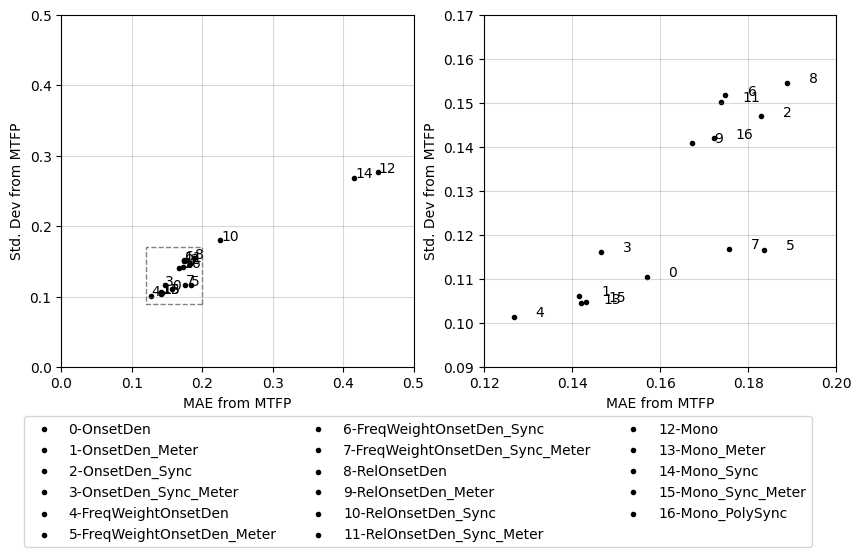

In [63]:
fig, (ax,small)= plt.subplots(1,2,figsize=(10,14),gridspec_kw={'width_ratios': [1,1]})

for i in range(17):
    if results[i][2]<0.2 and results[i][14]<0.2:
        small.scatter(results[i][2], results[i][14], color='black', marker=".",label=f"{i}-{flatterns_names[i]}")
        small.text(results[i][2]+0.005, results[i][14], i)
small.set_ylabel("Std. Dev from MTFP")
small.set_xlabel("MAE from MTFP")
small.set_xlim([0.12,0.2])
small.set_ylim([0.09,0.17])
small.grid(color='grey',alpha=0.3)
small.set_aspect('equal')

ax.set_aspect('equal')
p1 = (0.12, 0.09) 
p2 = (0.2,0.17)
rect = mpl.patches.Rectangle((p2[0], p1[1]), p1[0] - p2[0], p2[1] - p1[1], linewidth=1, fill=False, edgecolor='grey',linestyle='--')
ax.add_patch(rect)
for i in range(17):
    ax.scatter(results[i][2], results[i][14], color='black', marker=".",label=f"{i}-{flatterns_names[i]}")
    ax.text(results[i][2]+0.001, results[i][14], i)
ax.set_ylabel("Std. Dev from MTFP")
ax.set_xlabel("MAE from MTFP")
ax.set_xlim([0,0.5])
ax.set_ylim([0,0.5])
ax.legend(bbox_to_anchor=(2.15, -0.12), ncols=3)
ax.grid(color='grey',alpha=0.3)
plt.show()

[0.46280818 0.53666252 0.54629813 0.68036329 0.69080159 0.70874236
 0.71104241 0.76124623 0.80362062 0.80611576 0.81238115 0.8341282
 0.83837918 0.84243819 0.84256158 0.87470375 0.88451403]


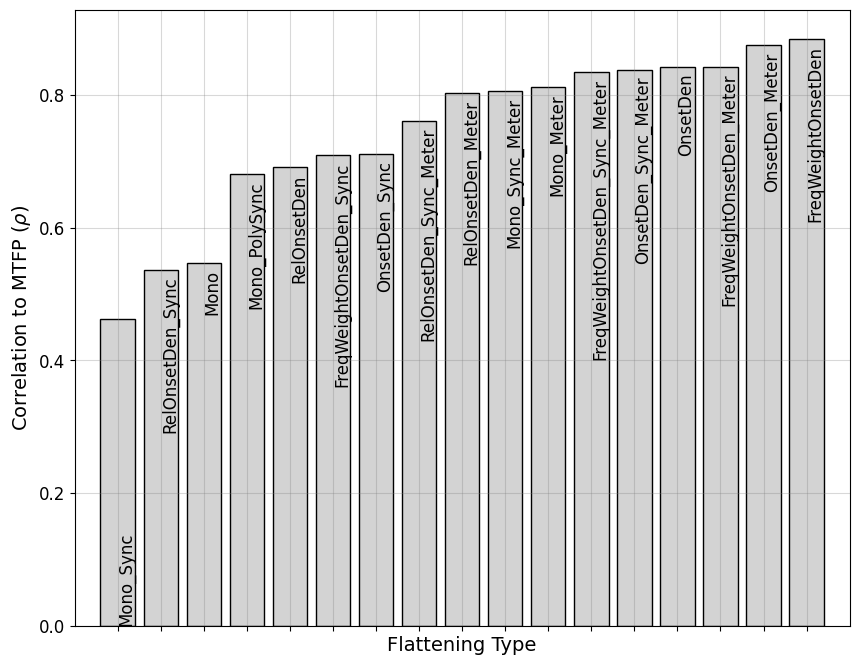

In [64]:
fig,(ax) = plt.subplots(figsize=(10,8))
data=0
rho_order = np.argsort(results[:,data])
idx=np.arange(17)
ax.bar(idx, results[:,data][rho_order], color='lightgrey', edgecolor='black')
print(results[:,data][rho_order])
for i in range(17):
    r = rho_order[i]
    y=0 if i==0 else results[:,data][rho_order][i]-0.01
    va='top' if i!=0 else 'bottom'
    ax.text(idx[i], y, f"{flatterns_names[r]}", fontsize='large',va=va,rotation="vertical")
ax.set_ylabel(r"Correlation to MTFP ($\rho$)", fontsize=14)
ax.set_xlabel("Flattening Type", fontsize=14)
ax.set_xticks(idx)
ax.set_xticklabels(idx[rho_order], visible=False)
ax.set_xlim([-1,17])
#ax.set_ylim([0,1])
ax.tick_params(labelsize=12)
ax.grid(color='grey',alpha=0.3)
plt.show()

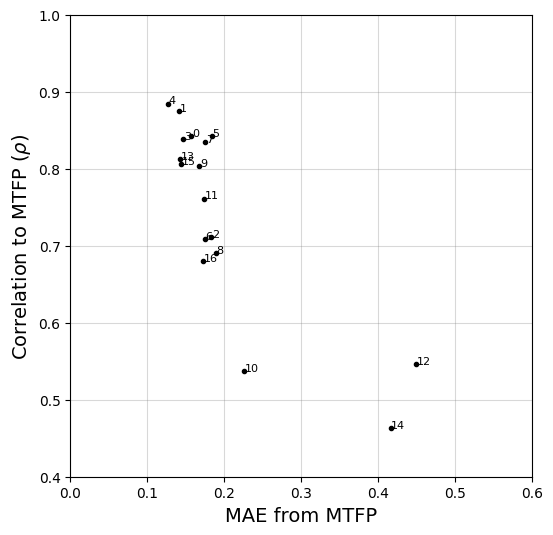

In [65]:
fig, ax= plt.subplots(figsize=(12,6))

p1 = (0.12, 0.09) 
p2 = (0.2,0.17)
rect = mpl.patches.Rectangle((p2[0], p1[1]), p1[0] - p2[0], p2[1] - p1[1], linewidth=1, fill=False, edgecolor='grey',linestyle='--')
ax.add_patch(rect)
for i in range(17):
    ax.scatter(results[i][2], results[i][0], color='black', marker=".",label=f"{i}-{flatterns_names[i]}")
    ax.text(results[i][2]+0.001, results[i][0], i, fontsize=8)
ax.set_ylabel(r"Correlation to MTFP ($\rho$)", fontsize=14)
ax.set_xlabel("MAE from MTFP", fontsize=14)
ax.set_xlim([0,0.6])
ax.set_ylim([0.4,1])
#ax.legend(bbox_to_anchor=(2.15, -0.12), ncols=3)
ax.grid(color='grey',alpha=0.3)
ax.set_aspect('equal')
plt.show()